In [1]:
from FastCDF import fastCDF
import seaborn as sns
import matplotlib.pylab as plt
import numpy as np

## FastCDF python usage example 

We start with a normal distribution in 2 dimensions. 
### FastCDF
This is closely related to a fast histogramming function in that it counts samples in cells and gives the cumulative sum on a regular grid.

In [2]:
mean = (.0, .5)
cov = [[1, 0], [0, 1]]
x = np.random.multivariate_normal(mean, cov, (300)).T
x.shape

(2, 300)

In [3]:
nb = 1000000
#x = np.random.normal(size=(2,nb));
mean = (-1, 1)
cov = [[1, 0], [0, 1]]
x = np.random.multivariate_normal(mean, cov, (nb)).T

# y =1 for simple CDF
y =  np.ones([nb])

# define the grid (same in both dimension)
Ng = 100
xm = 4
xg = np.linspace(-xm,xm, Ng)
yg = np.linspace(-xm*0.8,xm, Ng)
zg = [xg,yg]
cdf = fastCDF(x,zg,y).reshape(Ng,Ng)

In [4]:
print(cdf.shape)
np.max(cdf), cdf[0,0]

(100, 100)


(0.9986100000000002, 0.0)

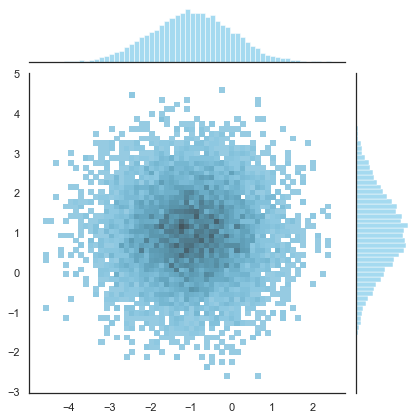

In [5]:
ns = 100
sns.set(style="white", color_codes=True)
sns.jointplot(x=x[0,::ns], y=x[1,::ns], kind='hist', color="skyblue");

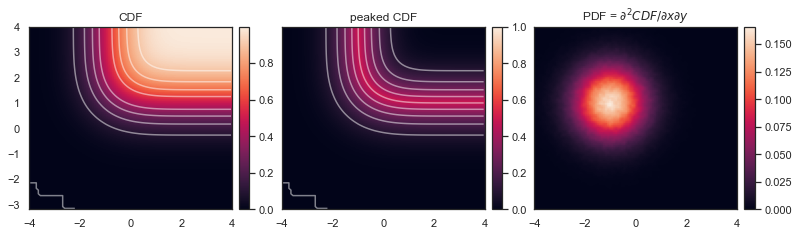

In [6]:
grad = np.gradient(cdf,xg, axis=0)
der2  = np.gradient(grad.reshape(Ng,Ng),yg, axis=1)
ga = der2
from mpl_toolkits.axes_grid1 import ImageGrid
from mpl_toolkits.axes_grid1 import AxesGrid
plt.rcParams["mpl_toolkits.legacy_colorbar"] = False
pcdf = np.minimum(cdf,1-cdf) # peaked CDF
fig = plt.figure(figsize=(13,6))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 3), axes_pad=0.45,cbar_mode="each",cbar_location="right",cbar_pad=0.1)
cc = grid[0].imshow(cdf,origin='lower', extent=[xg.min(),xg.max(),yg.min(),yg.max()])
grid[1].contour(cdf,origin='lower', extent=[xg.min(),xg.max(),yg.min(),yg.max()],colors="white",alpha=.5,
                    levels=np.linspace(0,1,11))
grid[0].set_title("CDF")
grid.cbar_axes[0].colorbar(cc)
#fig.colorbar(cc)
c = grid[1].imshow(pcdf,origin='lower', extent=[xg.min(),xg.max(),yg.min(),yg.max()],vmax=1)
grid[0].contour(pcdf,origin='lower', extent=[xg.min(),xg.max(),yg.min(),yg.max()],colors="white",alpha=.5,
                    levels=np.linspace(0,1,11))
grid[1].set_title("peaked CDF")
grid.cbar_axes[1].colorbar(c)
ccc = grid[2].imshow(ga,origin='lower', extent=[xg.min(),xg.max(),yg.min(),yg.max()])
grid[2].set_title(r"PDF = $\partial^2 CDF/\partial x \partial y$")
grid.cbar_axes[2].colorbar(ccc)
plt.show()

We plot the CDF, the peaked CDF $\equiv min(CDF(x,y), 1-CDF(x,y))$, and $\partial^2 CDF/\partial x \partial CDF/\partial y$ with contour levels at 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0.

### FastCDFOnSample

In [7]:
from FastCDF import fastCDFOnSample
cdfos = fastCDFOnSample(x,y)

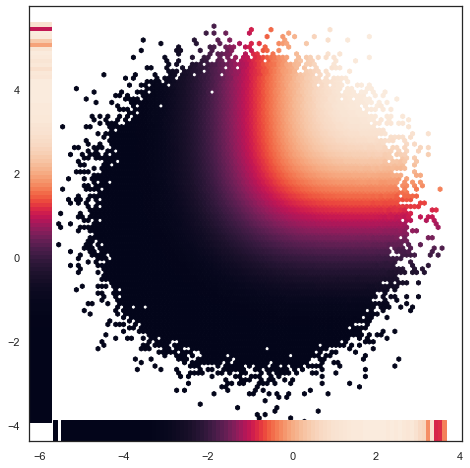

In [8]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot()
ax.set_aspect("equal")
ns = 1
plt.hexbin(x[0,::ns], x[1,::ns], C=cdfos[::ns],marginals=True,
        reduce_C_function=np.max);

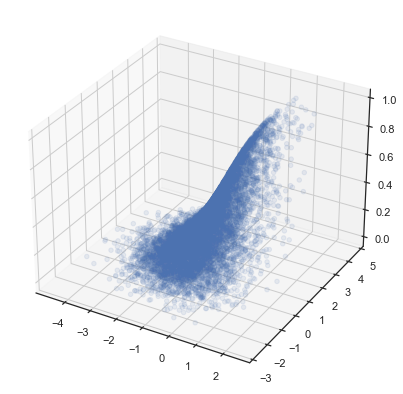

In [9]:
from mpl_toolkits import mplot3d
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
ns = 100
ax.scatter(x[0,::ns], x[1,::ns], cdfos[::ns],'.',alpha=.1);

## Check performance

In [10]:
def gridECDF2D(xx,yy,xgi,ygi):
    h2d, xe, ye =  np.histogram2d(xx,yy,bins=(np.insert(xgi, 0, np.NINF),np.insert(ygi, 0, np.NINF)))
    return np.cumsum(np.cumsum(h2d ,axis=0),axis=1)/len(xx)

cdf2 = gridECDF2D(x[1,:],x[0,:], yg, xg);

In [11]:
%timeit cdf2 = gridECDF2D(x[0,:],x[1,:], xg, yg)
%timeit cdf = fastCDF(x,zg,y).reshape(Ng,Ng)

108 ms ± 2.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
215 ms ± 2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


On my machine using the numpy functions is about twice as fast for large samples than the FastCDF routine. However, this is true only when using more than 10,000 points or so. Below that number both are more or less the same speed.

In [12]:
Ntest = 1000
%timeit cdf2 = gridECDF2D(x[0,:Ntest],x[1,:Ntest], xg, yg)
%timeit cdf = fastCDF(x[:,:Ntest],zg,y[:Ntest]).reshape(Ng,Ng)

330 µs ± 5.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
273 µs ± 5.18 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


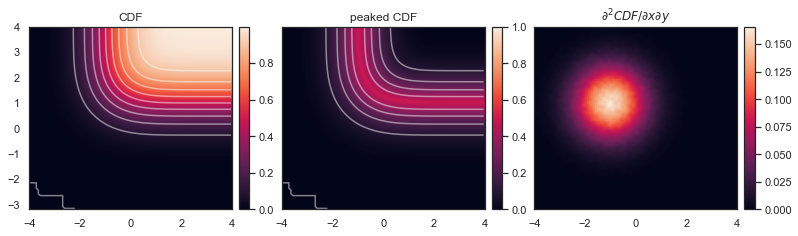

In [13]:
# Here we repeat the plot from above 
grad2 = np.gradient(cdf2,xg, axis=0)
der2  = np.gradient(grad2.reshape(Ng,Ng),yg, axis=1)
ga2 = der2
from mpl_toolkits.axes_grid1 import ImageGrid
from mpl_toolkits.axes_grid1 import AxesGrid
plt.rcParams["mpl_toolkits.legacy_colorbar"] = False
pcdf2 = np.minimum(cdf2,1-cdf2) # peaked CDF
fig = plt.figure(figsize=(13,6))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 3), axes_pad=0.45,cbar_mode="each",cbar_location="right",cbar_pad=0.1)
cc = grid[0].imshow(cdf2,origin='lower', extent=[xg.min(),xg.max(),yg.min(),yg.max()])
grid[0].contour(cdf2,origin='lower', extent=[xg.min(),xg.max(),yg.min(),yg.max()],colors="white",alpha=.5,
                    levels=np.linspace(0,1,11))
grid[0].set_title("CDF")
grid.cbar_axes[0].colorbar(cc)
#fig.colorbar(cc)
c = grid[1].imshow(pcdf2,origin='lower', extent=[xg.min(),xg.max(),yg.min(),yg.max()],vmax=1)
grid[1].contour(pcdf2,origin='lower', extent=[xg.min(),xg.max(),yg.min(),yg.max()],vmax=1,colors="white",alpha=.5,
                    levels=np.linspace(0,1,11))
grid[1].set_title("peaked CDF")
grid.cbar_axes[1].colorbar(c)
ccc = grid[2].imshow(ga2,origin='lower', extent=[xg.min(),xg.max(),yg.min(),yg.max()])
grid[2].set_title(r"$\partial^2 CDF/\partial x \partial y$")
grid.cbar_axes[2].colorbar(ccc)
plt.show()

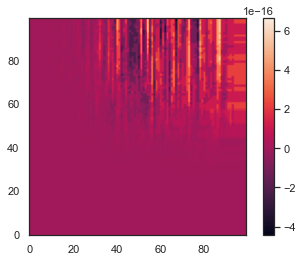

In [14]:
plt.imshow(cdf-cdf2, origin="lower")
plt.colorbar();

In [15]:
np.random.seed(43)
Ns = 32
x = np.random.uniform(size=(Ns,2) )
ecdf = fastCDFOnSample(x.T,np.ones(Ns))

Text(0.5, 1.0, '2D fastCDFOnSample labeled by their ECDF rank')

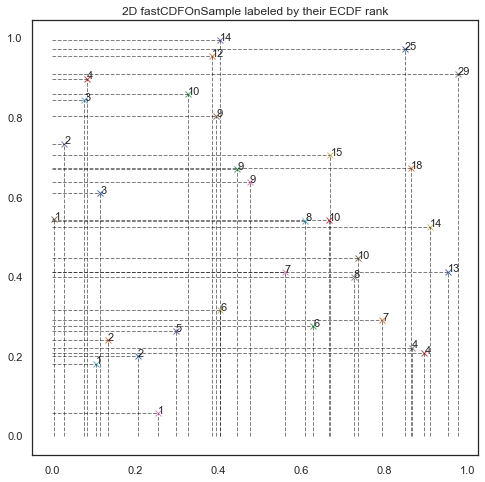

In [16]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot()
for i in range(Ns):
    plt.plot(x[i,0],x[i,1],'x')
    plt.plot([x[i,0],x[i,0]], [0, x[i,1]],'--',alpha=.5,color="black",lw=1)
    plt.plot([0, x[i,0]], [x[i,1],x[i,1]], '--',alpha=.5,color="black",lw=1)
    plt.text(x[i,0],x[i,1],'{0}'.format(np.int(ecdf[i]*Ns)),fontsize=11)
plt.title("2D fastCDFOnSample labeled by their ECDF rank")

In [18]:
plt.savefig("./Plot_fastCDFOnSample.png");

<Figure size 432x288 with 0 Axes>